In [1]:
import sys
import os
sys.path.append(os.path.abspath("Algorithms/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from XVA import *
from XVAFBSNNs import *

In [3]:
from FBSNNs import *
from CallOptionsBasket import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = CallOptionsBasket(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
model.load_model("models/100DCallOptionXVAPaper.pth")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D+1] + 4 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
xvamodel = XVA(Xi, T, M, N, D, Mm, layers, mode, activation, model)

n_iter = 2 * 10**3
lr = 1e-3

In [12]:
n_iter = 21 * 10**3
lr = 1e-5

In [7]:
xvamodel.load_model("models/100DCallOptionFVAXVAPaper.pth")

In [8]:
n_iter = 1 * 10**3
lr = 1e-5

In [9]:
t_test, W_test, X_test, C_test = xvamodel.fetch_minibatch()
X_pred, Y_pred = xvamodel.predict(C_test, t_test, W_test, X_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(1):
    t_test_i, W_test_i, X_test_i, C_test_i = xvamodel.fetch_minibatch()
    X_pred_i, Y_pred_i = xvamodel.predict(C_test_i, t_test_i, W_test_i, X_test_i)
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)


In [9]:
Y_pred.shape

(128, 201, 1)

In [10]:
Y_preds = Y_pred.reshape(128, 201)

In [11]:
pred_fva = Y_preds[:,0][0]

In [12]:
pred_fva

0.04669775

In [13]:
from scipy.stats import multivariate_normal as normal
np.random.seed(0)
dw_sample = normal.rvs(size=[50000, D, N]) * np.sqrt(T/N)
x_sample = np.zeros([50000, D, N + 1]) 
x_sample[:, :, 0] = np.ones([50000, D])
factor = np.exp((0.01-(0.25**2)/2)*(T/N))
for i in range(N):   
    x_sample[:, :, i + 1] = (factor * np.exp(0.25 * dw_sample[:, :, i])) * x_sample[:, :, i]
np.random.seed(1)
dw_sample1 = normal.rvs(size=[50000, D, N]) * np.sqrt(T/N)
x_sample1 = np.zeros([50000, D, N + 1])
x_sample1[:, :, 0] = np.ones([50000, D]) 
factor = np.exp((0.01-(0.25**2)/2)*(T/N))
for i in range(N):   
    x_sample1[:, :, i + 1] = (factor * np.exp(0.25 * dw_sample1[:, :, i])) * x_sample1[:, :, i]

In [22]:
portfolio1 = np.sum(x_sample, axis=1, keepdims=True)
portfolio2 = np.sum(x_sample1, axis=1, keepdims=True)

In [23]:
payoff1 = np.maximum(portfolio1 - 100, 0)
payoff2 = np.maximum(portfolio2 - 100, 0)

In [24]:
average_1 = np.mean(payoff1, axis=0, keepdims=True)
average_2 = np.mean(payoff2, axis=0, keepdims=True)

In [25]:
average = (average_1 + average_2)/ 2

In [27]:
mc_price = np.exp(-0.01 * 1) * average[:, :, 200]

In [28]:
mc_price[0][0]

1.5799232739802955

In [30]:
mc_price_rf = np.exp(-0.04 * 1) * average[:, :, 200]

In [31]:
mc_price_rf[0][0]

1.5332294845835137

In [32]:
exact_fva = mc_price[0][0] - mc_price_rf[0][0]

In [33]:
pred_fva * 100

4.669775068759918

In [34]:
exact_fva * 100

4.6693789396781815

In [35]:
(pred_fva - exact_fva) ** 2 / exact_fva ** 2

7.197061504281103e-09

In [36]:
np.abs(pred_fva - exact_fva) / exact_fva * 100

0.008483549672325319

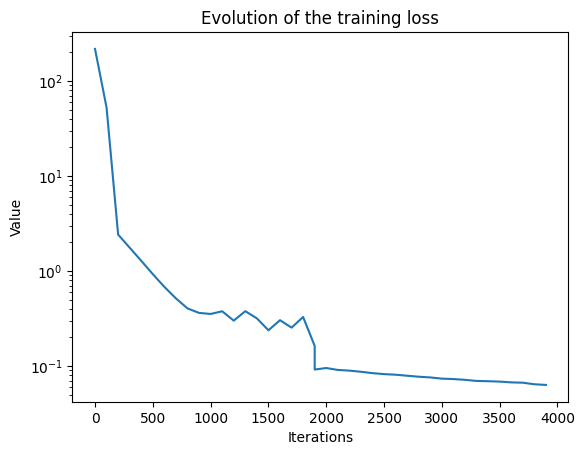

In [37]:
graph = xvamodel.iteration, xvamodel.training_loss
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.show()

In [13]:
xvamodel.save_model("models/100DCallOptionFVAXVAPaper.pth")